In [1]:
# Import the necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import the data
df = pd.read_csv("listings-03-29-21-09.csv")


### Let's Take a peak at the data

In [3]:
df.head()

,Category,Yard,Parking Type,heating,State,City,Zip,Seller Type,School District,Seller Accepts Texts,...,Exterior Material,cooling,Bathrooms,Bedrooms,Ad Status,Special Features,Floor Covering,Basement Type,Included Appliances,mls number
0,townhouse/condo,fenced full,attached garage|combined garage|2 cars,forced air,ut,herriman,84096,by agent,jordan,True,...,clapboardmasonite|stucco,central air,3.75,4,active,fireplace gas|patio uncovered|pool|security sy...,carpet|hardwood|linoleum,full finished,microwave|range|refrigerator,1587020
1,single family home,landscape full,attached garage|combined garage|3 cars,forced air,ut,farmington,84025,by agent,not specified,True,...,other|stucco,central air,2.50,4,active,not specified,carpet|hardwood|other|tile,not specified,microwave|refrigerator,3051017
2,single family home,fenced full|landscape full,attached garage|combined garage|2 cars,forced air,ut,lehi,84043,by agent,alpine,True,...,stucco,central air,3.00,5,active,fireplace gas|sprinklers automatic|walkin closet,carpet|tile,full unfinished,microwave|range,1589044
3,single family home,fenced partial|landscape full,attached garage|combined garage|2 cars,forced air,ut,delta,84624,by agent,millard,True,...,stucco,central air,3.00,6,active,fireplace woodburning|patio covered|sprinklers...,carpet|tile,full finished,not specified,1570632
4,single family home,fenced partial,attached garage|combined garage|2 cars,forced air,ut,bountiful,84010,by owner,davis,True,...,brick|cedarredwood,central air,3.00,4,active,deck|fireplace gas|fireplace woodburning|patio...,carpet|hardwood|tile,full finished,dryer|microwave|range|refrigerator|washer,not specified


There are a lot of features that probably won't do us much good. (e.g. MLS # or State as we're only handling Utah houses) Also notice how many of the interesting features like Parking Type and Exterior Material are strings of smaller features, let's try and pull those out.

In [4]:
# Adjust formats as needed

# Adjust appropriate strings to numerics
df['Acres'] = pd.to_numeric(df['Acres'], errors='coerce')
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
df['Year Built'] = pd.to_numeric(df['Year Built'], errors='coerce', downcast='integer')
df['Square Feet'] = pd.to_numeric(df['Square Feet'], errors='coerce', downcast='integer')

# # Adjust some features to categories
# df['Seller Type'] = df['Seller Type'].astype('category')
# df['cooling'] = df['cooling'].astype('category')
# df['heating'] = df['heating'].astype('category')
# df['Basement Type'] = df['Basement Type'].astype('category')
# df['Category'] = df['Category'].astype('category')


In [5]:
# Break some categories into more nuanced ones
df['Carpet'] = pd.np.where(df['Floor Covering'].str.contains("carpet"), True, False)
df['Hard Wood'] = pd.np.where(df['Floor Covering'].str.contains("hardwood"), True, False)
df['Tile'] = pd.np.where(df['Floor Covering'].str.contains("tile"), True, False)
df['Laminate'] = pd.np.where(df['Floor Covering'].str.contains("laminate"), True, False)

df['Finished Basement'] = pd.np.where(df['Basement Type'].str.contains("full finished|full partially finished"), True, False)

df['Garage'] = pd.np.where(df['Parking Type'].str.contains("garage"), True, False)

df['Fireplace'] = pd.np.where(df['Special Features'].str.contains("fireplace"), True, False)
df['Deck'] = pd.np.where(df['Special Features'].str.contains("deck"), True, False)
df['Sprinklers'] = pd.np.where(df['Special Features'].str.contains("sprinklers"), True, False)
df['Pool'] = pd.np.where(df['Special Features'].str.contains("pool"), True, False)

df['By Owner'] = pd.np.where(df['Seller Type'].str.contains("by owner"), True, False)

df['Washer'] = pd.np.where(df['Included Appliances'].str.contains("washer"), True, False)
df['Dryer'] = pd.np.where(df['Included Appliances'].str.contains("dryer"), True, False)

df['Fenced'] = pd.np.where(df['Yard'].str.contains("fenced full|fenced partial"), True, False)
df['Landscape'] = pd.np.where(df['Yard'].str.contains("landscape full|landscape partial|landscape front|landscape back"), True, False)

df['Central Air'] = pd.np.where(df['cooling'].str.contains("central air"), True, False)

df['Brick'] = pd.np.where(df['Exterior Material'].str.contains("brick"), True, False)
df['Stucco'] = pd.np.where(df['Exterior Material'].str.contains("stucco"), True, False)

#### Now that we've created some new columns from the old ones of features let's drop those old columns and remove some outliers that will throw off our models. 

In [6]:
# Drop Non-Utah Listings
df = df[df['State'] == "ut"]

# Drop useless features
uselessFeatures = ['Ad Status', 'Package Type', 'mls number', 'AD ID', 'Title']
df = df.drop(uselessFeatures, axis=1)

# Obsolete because we formed simple boolean columns from them
obsoleteFeatures = ['State', 'Exterior Material', 'Parking Type', 'cooling', 'heating', 'Basement Type', 'Seller Type', 'Included Appliances']
df = df.drop(obsoleteFeatures, axis=1)


# Drop Extreme price outliers (between 50k and 5m)
df = df[df['Asking Price'] < 5000000] 
df = df[df['Asking Price'] > 50000]

# Drop improper years
df = df[df['Year Built'] > 1850]

# Drop extremely high/low Sqaure Feet listings (11000sqft = .25 acre (roughly))
df = df[df['Square Feet'] < 11000]
df = df[df['Square Feet'] > 500]



In [11]:
df.dtypes

Category                 object
Yard                     object
City                     object
Zip                      object
School District          object
Seller Accepts Texts       bool
Photo Count               int64
Year Built              float64
Acres                   float64
Square Feet             float64
Newly Built                bool
Seller ID                 int64
Time Posted              object
Asking Price              int64
Bathrooms               float64
Bedrooms                float64
Special Features         object
Floor Covering           object
Carpet                     bool
Hard Wood                  bool
Tile                       bool
Laminate                   bool
Finished Basement          bool
Garage                     bool
Fireplace                  bool
Deck                       bool
Sprinklers                 bool
Pool                       bool
By Owner                   bool
Washer                     bool
Dryer                      bool
Fenced  

### Let's look at how correlated these all are with a correlation heatmap

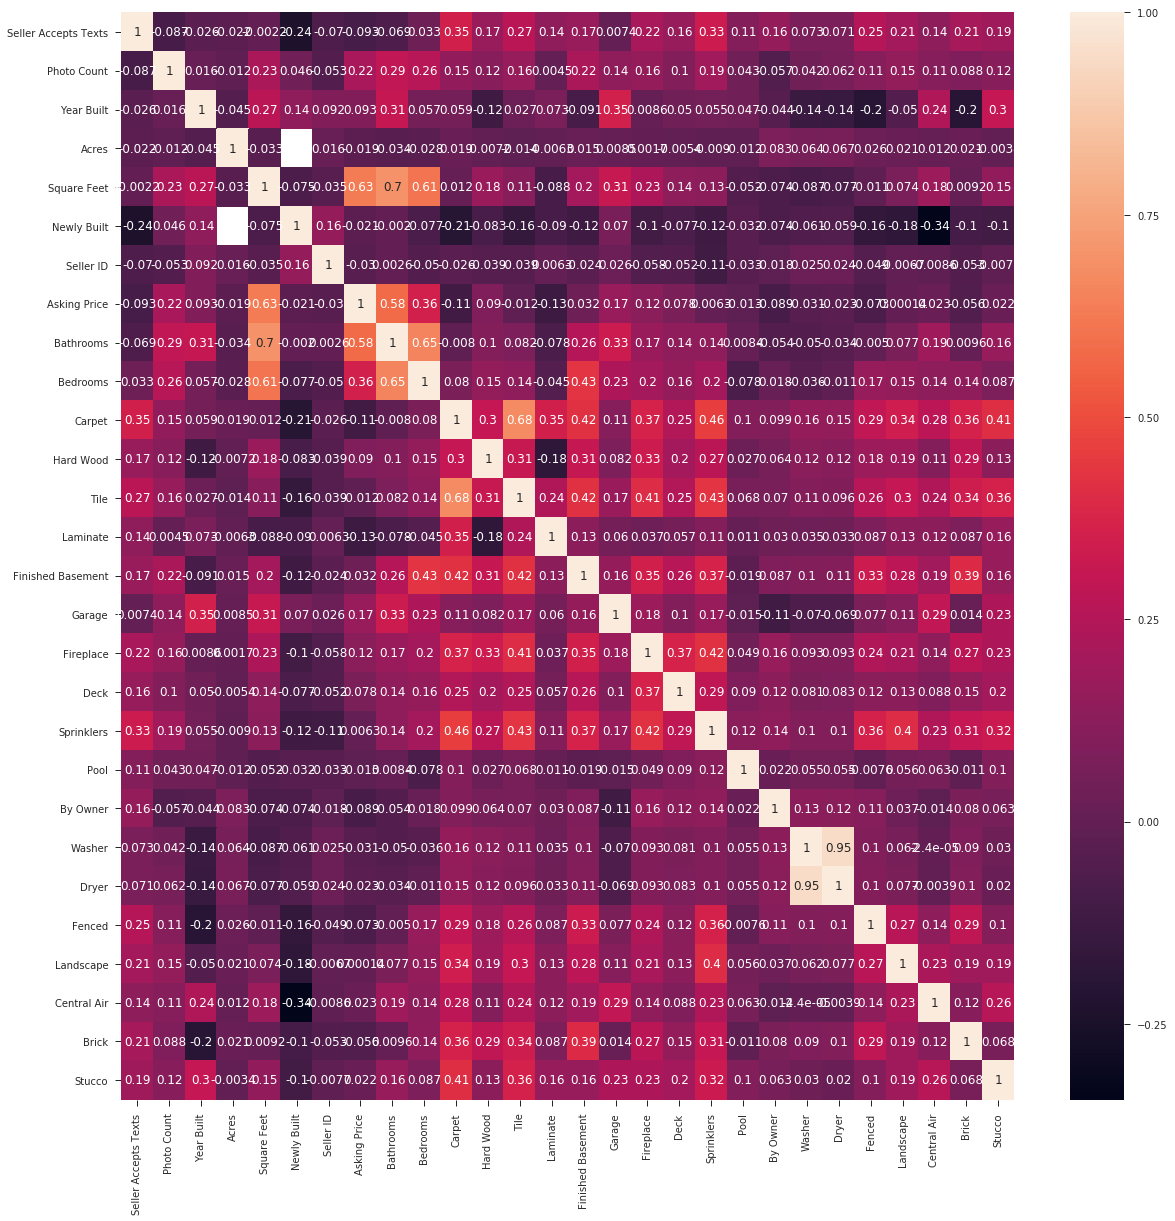

In [12]:
# calculate the correlation matrix
corr = df.corr()

# plot the correlation heatmap
plt.figure(figsize=(20, 20))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

#### Hmm, not that great. Let's simply out analysis to just the clearly significant features for now.

In [17]:
# Save the newly formatted DataFrame to a csv again
# df.to_csv (r'export_dataframe.csv', index = None, header=True) 

quant_feats = ['Asking Price', 'Bedrooms', 'Bathrooms', 'Year Built', 'Square Feet']
df2 = df[quant_feats].copy()

# reg_df = df[['Asking Price', 'Bedrooms', 'Bathrooms','Category',
#              'Seller Accepts Texts', 'Photo Count', 'Year Built',
#              'Acres', 'Square Feet', 'Newly Built', 'Carpet', 'Hard Wood',
#              'Tile', 'Laminate', 'Finished Basement', 'Garage', 'Fireplace',
#              'Deck', 'Sprinklers', 'Pool', 'By Owner', 'Washer', 'Dryer',
#              'Fenced', 'Landscape', 'Central Air', 'Brick', 'Stucco']]

# Let's drop the NaN values while we're at it
df2 = df2.dropna()

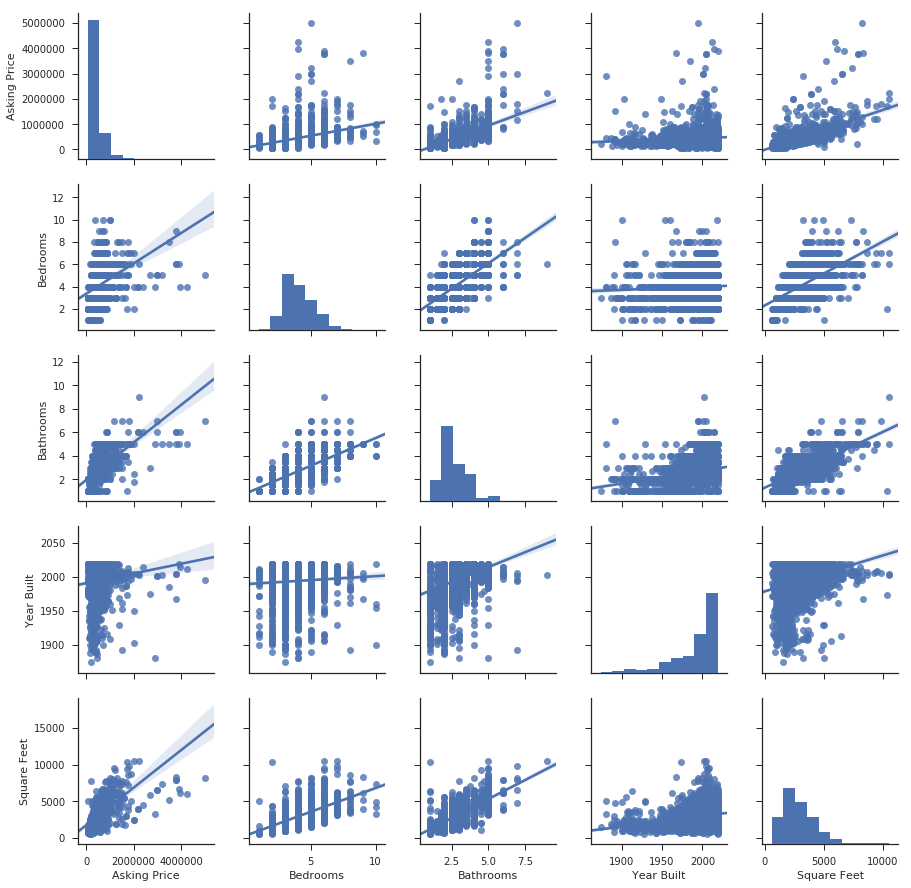

In [18]:
# Initial EDA Charts
sns.set(style='ticks')
sns.pairplot(df2, kind='reg')

## Now let's split out test and train data and build out a model and evaluate the accuracy (by running the model several times on different train/test splits

In [19]:
from sklearn.model_selection import train_test_split

# Helper function for later
def my_tt_split(df):
    train, test = train_test_split(df, test_size=0.2)

    # seperate Y and X
    train_y = train['Asking Price']
    train_y = train_y.values
    del train['Asking Price']
    train_x = train.values

    test_y = test['Asking Price']
    test_y = test_y.values
    del test['Asking Price']
    test_x = test.values
    
    return train_x, train_y, test_x, test_y

In [20]:
train_x, train_y, test_x, test_y = my_tt_split(df2)

In [21]:
def getModelAccuracy(df, model, runs=20):
    accuracies = []
    for i in range(runs):
        # Linear Model
        if model == 'lm':
            lm = linear_model.LinearRegression()
            train_x, train_y, test_x, test_y = my_tt_split(df)
            model.fit(train_x, train_y)
            accuracies.append(lm.score(test_x, test_y))
        # Gradient Boosting Regressor
        elif model == 'gbr':
            gbr = GradientBoostingRegressor(n_estimators=100, max_depth=4)
            gbr.fit(train_x, train_y)
            accuracies.append(gbr.score(test_x, test_y))

    return sum(accuracies) / len(accuracies)

In [22]:
#Train a Linear Regression model and test it's accuracy
from sklearn import linear_model

lm = linear_model.LinearRegression()

# Fit the model
train_x, train_y, test_x, test_y = my_tt_split(df2)
lm.fit(train_x, train_y)

# Get the accuracy
print("Linear Regression Model Accuracy: ", round(lm.score(test_x, test_y), 3))

#Prediction on an arbitrary value
print("Predicted value:\t" + str(lm.predict([test_x[142]])[0]))
print("Real value:\t\t" + str(test_y[142]))

Linear Regression Model Accuracy:  0.453
Predicted value:	4843.520199157298
Real value:		219900


### Hmm, not that great, let's try some other models

In [23]:
#Train the model
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)

#Fit
train_x, train_y, test_x, test_y = my_tt_split(df2)
GBR.fit(train_x, train_y)

print("Gradient Boosting Regressor Accuracy: ", round(GBR.score(test_x, test_y), 3))

prediction_str = str(int(GBR.predict([test_x[142]])[0]))
print("Predicted value:\t", prediction_str)
print("Real value:\t\t", test_y[142])

Gradient Boosting Regressor Accuracy:  0.341
Predicted value:	 369203
Real value:		 399900


#### Still not good, let's try this again while applying a log transformation to the response variable (it's very right skewed)

/home/joshua/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


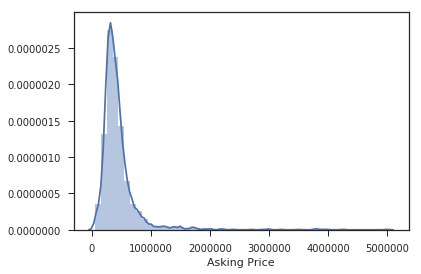

In [24]:
# The data is very right skewed, let's adjust that.
sns.distplot(df2['Asking Price'], )

df2_log = df2.copy()
df2_log.is_copy = False
df2_log["Asking Price"] = np.log(1 + df2_log['Asking Price'])

/home/joshua/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


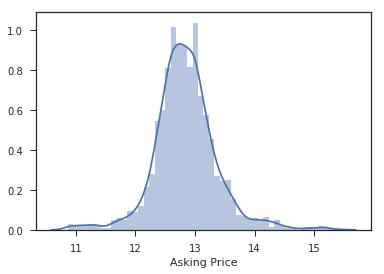

In [25]:
# Much Better
sns.distplot(df2_log['Asking Price'])

In [26]:
# Let's run the previous models again: Linear Regression
from sklearn import linear_model

lm = linear_model.LinearRegression()

# Fit the model
train_x, train_y, test_x, test_y = my_tt_split(df2_log)
lm.fit(train_x, train_y)

# Get the accuracy
print("Linear Regression Model Accuracy: ",lm.score(test_x, test_y))

#Prediction on an arbitrary value (NOTE: This model returns a response in log terms,
# we need to put to the e-th power to get the actual prediction)
prediction_str = str(int(np.exp(lm.predict([test_x[142]])[0])))
print("Predicted value:\t", prediction_str)
print("Real value:\t\t", int(np.exp(test_y[142])))

Linear Regression Model Accuracy:  0.5844094832671909
Predicted value:	 268664
Real value:		 299001


In [31]:
# Let's run the previous models again: GBR
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)

#Fit
train_x, train_y, test_x, test_y = my_tt_split(df2_log)
GBR.fit(train_x, train_y)

print("Gradient Boosting Regressor Accuracy: ", round(GBR.score(test_x, test_y), 3))

#Prediction on an arbitrary value (NOTE: This model returns a response in log terms,
# we need to put to the e-th power to get the actual prediction)
prediction_str = str(int(np.exp(GBR.predict([test_x[142]])[0])))
print("Predicted value:\t", prediction_str)
print("Real value:\t\t", int(np.exp(test_y[142])))

Gradient Boosting Regressor Accuracy:  0.677
Predicted value:	 343921
Real value:		 219901


### We're averaging in the 60% now so that log transformation helped. Let's make a function to automate that step for the future. Then let's try again over a smaller subset, let's capture just the houses under half a million

In [32]:
def logY(df):
    # Deep copy the dataframe
    df_log = df.copy()
    
    # Tell the compiler it's not a shallow copy, otherwise the next line will throw an exception
    df_log.is_copy = False
    
    # Y = natural_log(Y)
    df_log["Asking Price"] = np.log(1 + df_log['Asking Price'])
    
    # Drop the missing values (if any)
    df_log = df_log.dropna()
    return df_log

In [33]:
cheap = df[df['Asking Price'] < 500000][quant_feats]
cheap = cheap.dropna()

expensive = df[df['Asking Price'] > 500000][quant_feats]
expensive = expensive.dropna()

cheap_log = logY(cheap)
expensive_log = logY(expensive)

# Test Cheap
lm = linear_model.LinearRegression()
train_x, train_y, test_x, test_y = my_tt_split(cheap)
lm.fit(train_x, train_y)
print("Accuracy (<500k): \t\t\t", round(lm.score(test_x, test_y), 3))

# Test Cheap (Log)
lm = linear_model.LinearRegression()
train_x, train_y, test_x, test_y = my_tt_split(cheap_log)
lm.fit(train_x, train_y)
print("Accuracy (<500k w/ log transform): \t", round(lm.score(test_x, test_y), 3))

# Test Expensive
lm = linear_model.LinearRegression()
train_x, train_y, test_x, test_y = my_tt_split(expensive)
lm.fit(train_x, train_y)
print("Accuracy (>500k): \t\t\t", round(lm.score(test_x, test_y), 3))

# Test Expensive (Log)
lm = linear_model.LinearRegression()
train_x, train_y, test_x, test_y = my_tt_split(expensive_log)
lm.fit(train_x, train_y)
print("Accuracy (>500k w/ log Transform: )\t", round(lm.score(test_x, test_y), 3))

Accuracy (<500k): 			 0.546
Accuracy (<500k w/ log transform): 	 0.404
Accuracy (>500k): 			 0.308
Accuracy (>500k w/ log Transform: )	 0.465


### None of the above appears to help our accuracy. Above our previous baseline of ~60%, let''s see what we can parse out of the city data

In [30]:
# df['City Mean'] = df['Asking Price']
df.groupby('City')['Asking Price'].mean().astype(int)

City
alpine                      666333
american fork               454058
annabella                   275000
apple valley                429500
bear river city             770000
beaver                      399000
beaver dam                  449000
bluffdale                   563651
bluffdalel                  327900
bothwell                    777000
bountiful                   434092
brigham city                264883
brighton                    349900
cedar city                  311716
cedar hills                 480291
centerfield                 171899
centerville                 474772
chester                     472000
clearfield                  266684
clinton                     349450
coalville                   740000
coral canyon                479900
corinne                     614900
cottonwood heights          603177
cove                        449900
delta                       185000
draper                      697363
draper ut cnty              382500
duchesne       